In [7]:
import sys
sys.path.append('../paleogeography')
sys.path.append('../paleotopography')
sys.path.append('../pigplates/')
sys.path.append('../pygplates2014/')
sys.path.append('/Users/Simon/GIT/PlateTectonicTools/')

import pygplates
import glob, re
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import xarray as xr

import polygon_processing as pp
import paleogeography as pg
import paleogeography_tweening as pgt
import paleotopography as pt

from proximity_query import *
from create_gpml import create_gpml_regular_long_lat_mesh
import points_in_polygons
from sphere_tools import sampleOnSphere
import points_spatial_tree

from ptt.utils.call_system_command import call_system_command
import tempfile


sys.path.append('/Users/Simon/GIT/GPlatesClassStruggle/')
from reconstruction_classes import *
from raster_reconstruction_classes import *


%matplotlib inline
%load_ext autoreload
%autoreload 2


reconstruction_basedir = '../../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles/'
tween_basedir = '../tween_feature_collections_gpml/'
file_format = 'gpml'

output_dir = './paleotopo_grids_tests/'

netcdf3_output = False

#rotation_model = pygplates.RotationModel(['%s/Global_EB_250-0Ma_GK07_Matthews++.rot' % reconstruction_basedir,
#                                          '%s/Global_EB_410-250Ma_GK07_Matthews++.rot' % reconstruction_basedir])
rotation_file = '%s/Global_EarthByte_230-0Ma_GK07_AREPS.rot' % reconstruction_basedir


COBterrane_file = '%s/Global_EarthByte_GeeK07_COB_Terranes_Matthews_etal.gpml' % reconstruction_basedir

agegrid_file_template = '/Users/Simon/Data/AgeGrids/Agegrids_30m_20151002_2015_v1_r756/agegrid_30m_%d.grd'


#############################################
## Set the heights for different environment
#############################################
depth_for_unknown_ocean = -1000
# ----------------------------------
shallow_marine_elevation = -200.
# ----------------------------------
lowland_elevation = 200.
# ----------------------------------
max_mountain_elevation = 1500.
# NOTE - this height is actually the mountain height IN ADDITION TO the lowland height
# so that the maximum absolute elevation would be [lowland_elevation + max_mountain_elevation]
# TODO should call this 'mountain_relief'???
#############################################

# the grid sampling for the output
sampling = 0.5

# this number controls how small polygons are exclude when merging the COB terranes into 
# land/sea masking polygons
area_threshold = 0.0001

# used for quadtree
subdivision_depth = 2

# this buffer defines the smoothness of the topography at the transition from 'lowland' to 'mountain'
# the distance defined here is the distance over which heights ramp from the lowland elevation to the 
# mountain elevation defined above. (the ramping takes place from the edge of the mountain range inwards
# towards the mountain interior). Any parts of the mountain range greater than this buffer distance from 
# the edge will have a uniform height equal to max_mountain_elevation
mountain_buffer_distance_degrees = 1.
#mountain_buffer_distance_degrees = 2.

# choose here either 'ocean' or 'land'
# this determines which grid takes precedence where both the age grid and the 
# paleogeographies overlap and contain valid values
land_or_ocean_precedence = 'land'

# this number is used in the final grdfilter step to smooth the output 
# NOTE this value is ignored if 'merge_with_bathymetry' is set to False
grid_smoothing_wavelength_kms = 1.


merge_with_bathymetry = True


####################################################

# make a sorted list of the (midpoint) times for paleogeography polygons
tmp = glob.glob('%s/*/' % reconstruction_basedir)

paleogeography_timeslice_list = []
for tm in tmp:
    paleogeography_timeslice_list.append(float(re.findall(r'\d+Ma+',tm)[1][:-2]))

paleogeography_timeslice_list.sort()

paleogeography_timeslice_list = np.array(paleogeography_timeslice_list)

print paleogeography_timeslice_list





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[   6.   14.   22.   33.   45.   53.   76.   90.  105.  126.  140.  152.
  169.  195.  218.  232.  255.  277.  287.  302.  328.  348.  368.  396.]


Working on Time 55.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['../../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['../../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


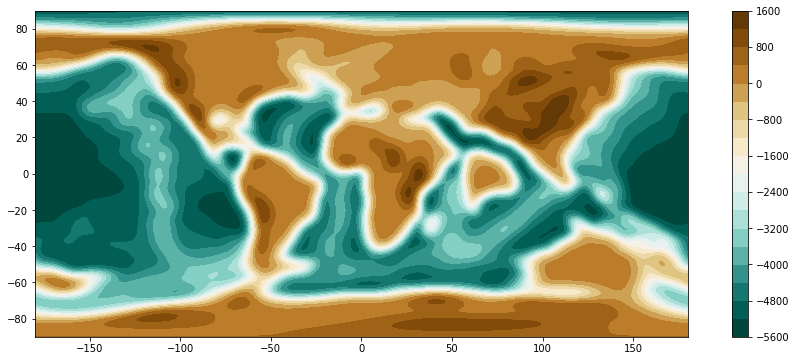

Working on Time 55.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['../../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['../../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


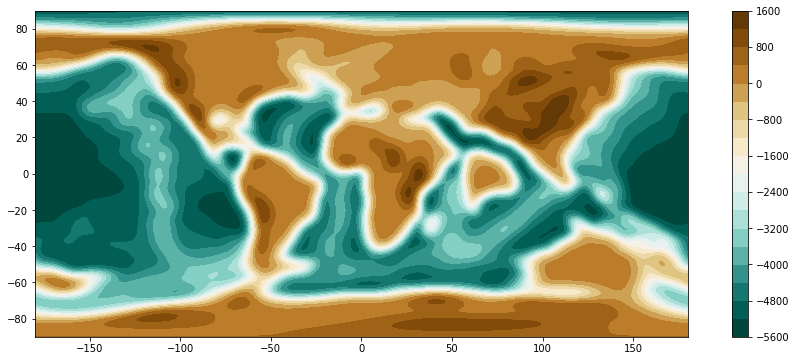

Working on Time 55.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['../../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['../../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


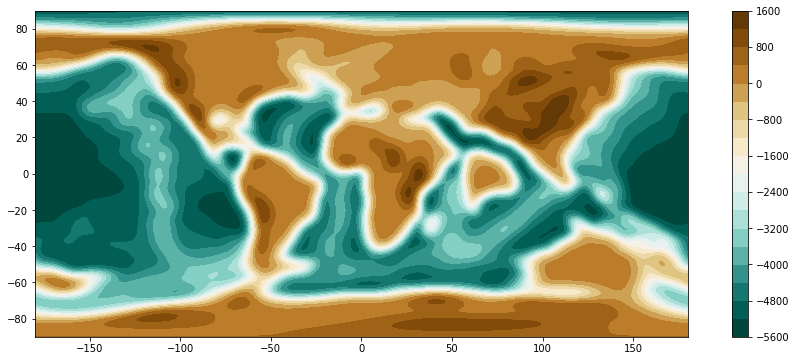

Working on Time 55.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['../../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['../../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


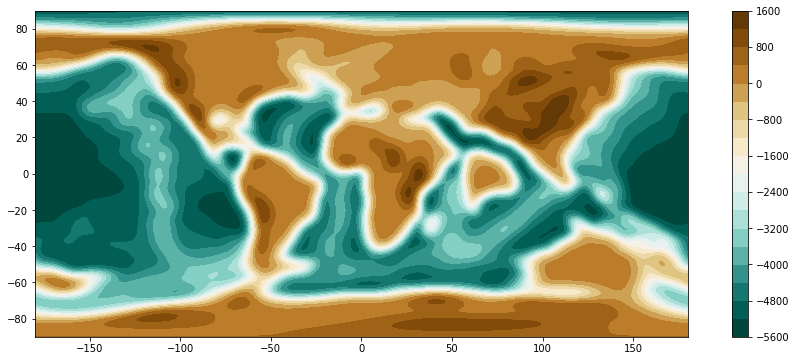

Working on Time 55.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['../../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['../../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


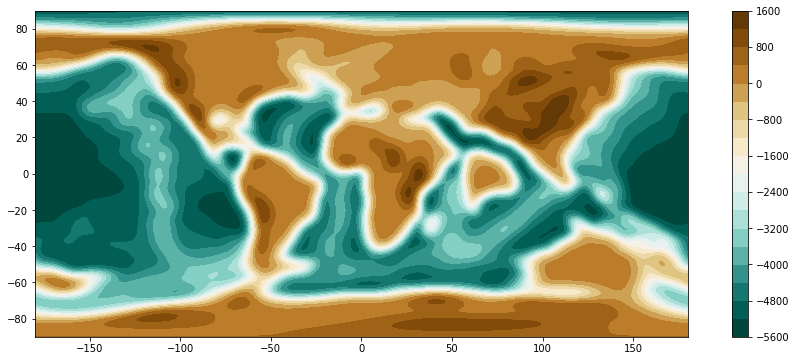

In [14]:
#from joblib import Parallel, delayed

# prepend 0 to the list, since this is not covered in published paleogeography sequence
paleogeography_timeslice_list = np.hstack((0,paleogeography_timeslice_list))

mountain_buffer_distance_degrees = 0.01
    
reconstruction_time = 55

for grid_smoothing_wavelength_kms in [1,250,500,1000,2000]:

    pt.paleotopography_job(reconstruction_time, paleogeography_timeslice_list, 
                           tween_basedir, reconstruction_basedir, output_dir, 
                           file_format, rotation_file, COBterrane_file, agegrid_file_template,
                           lowland_elevation, shallow_marine_elevation, max_mountain_elevation, depth_for_unknown_ocean, 
                           sampling, mountain_buffer_distance_degrees, area_threshold,
                           grid_smoothing_wavelength_kms, merge_with_bathymetry, netcdf3_output)
    
    
    ptopo = GplatesRaster('%s/paleotopobathy_buffer%0.2dd_filter%0.2fkm_%0.2fd_%0.2fMa.nc' % (output_dir,
                                                                                              mountain_buffer_distance_degrees,
                                                                                              grid_smoothing_wavelength_kms,
                                                                                              sampling, 
                                                                                              reconstruction_time))
    
    ptopo.plot(show=True)
    #plt.title('Filter wavelength %d km' % grid_smoothing_wavelength_kms)
    #plt.savefig('%s/paleotopobathy_filter%dkm_%0.2fd_%0.2fMa.png' % (output_dir, grid_smoothing_wavelength_kms, sampling, reconstruction_time))
    #plt.close()
    

